<a href="https://colab.research.google.com/github/palbha/End_to_end_Timeseries/blob/main/feature_engg_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
from feature_gen import *
#Creating Sample Data for Year 2024-2025
date_range = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
df = pd.DataFrame({'date': date_range})
df.date=pd.to_datetime(df.date)
np.random.seed(42)
days = np.arange(len(df))

sine_wave = np.sin(2 * np.pi * days / 365*2)
noise = np.random.normal(scale=0.3, size=len(df))
df['target'] = sine_wave + noise

<Axes: >

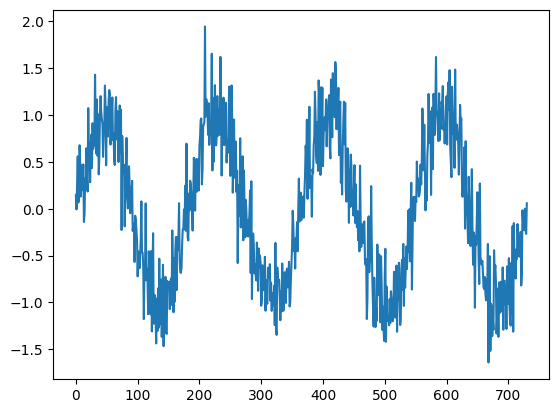

In [18]:
# This is how our timeseries look like
df['target'].plot()

In [19]:

#Creating Sample holidays_df for creating relevant feature
holidays_data = {
    'holiday_date': [
        '2024-01-01', '2025-01-01',  # New Year's Day
        '2024-02-14', '2025-02-14',  # Valentine's Day (not official holiday but event)
        '2025-04-18',  # Good Friday (example holiday)
        '2025-07-01',  # Canada Day
   '2024-10-11',      '2025-10-13',  # Thanksgiving (Canada)
        '2025-12-25',  # Christmas Day
        '2025-12-26',  # Boxing Day
    ],
    'holiday_name': [
        "New Year's Day", "New Year's Day",
        "Valentine's Day","Valentine's Day",
        "Good Friday",
        "Canada Day",
       "Thanksgiving", "Thanksgiving",
        "Christmas Day",
        "Boxing Day",
    ],
    'holiday_type': [
        "Public Holiday","Public Holiday",
        "Event","Event",
        "Public Holiday",
        "Public Holiday",
        "Public Holiday","Public Holiday",
        "Public Holiday",
        "Public Holiday",
    ]
}
holidays_df = pd.DataFrame(holidays_data)
holidays_df['holiday_date'] = pd.to_datetime(holidays_df['holiday_date'])




In [20]:
# Creating some events df - in case we want to treat events different than holidays
event_start = pd.to_datetime('2024-08-01')
event_end = pd.to_datetime('2024-08-13')

# Create a DataFrame with all dates in the event range
event_dates = pd.date_range(event_start, event_end, freq='D')

# Create the event DataFrame
back_to_school_event_df = pd.DataFrame({
    'event_date': event_dates,
    'event_name': 'Back_to_School_Sale'
})


In [34]:
#For each of the below function you can see the docstring to understand
print(create_date_features.__doc__)


    Create basic date-based features from a datetime column.

    Args:
        df (pd.DataFrame): Input dataframe containing the date column.
        date_col (str): Name of the datetime column in df.

    Returns:
        pd.DataFrame: DataFrame with new date features added.
            Features include:
                - year
                - month
                - day
                - day_of_week (0=Monday, 6=Sunday)
                - is_weekend (bool)
                - quarter
                - day_of_year
                - week_of_year
    


In [21]:
org_df=df.columns
df = create_date_features(df, 'date')
print("New columns - ",','.join(df.columns.difference(org_df)))
print(df.head(2))


New columns -  day,day_of_week,day_of_year,is_weekend,month,quarter,week_of_year,year
        date    target  year  month  day  day_of_week  is_weekend  quarter  \
0 2024-01-01  0.149014  2024      1    1            0       False        1   
1 2024-01-02 -0.007058  2024      1    2            1       False        1   

   day_of_year  week_of_year  
0            1             1  
1            2             1  


In [22]:
org_df=df.columns
df = create_rolling_features(df, target_col='target', windows=[3,7,14], funcs=['mean', 'std'])

print("New columns - ",','.join(df.columns.difference(org_df)))
print(df.head(2))

New columns -  target_roll_mean_14,target_roll_mean_3,target_roll_mean_7,target_roll_std_14,target_roll_std_3,target_roll_std_7
        date    target  year  month  day  day_of_week  is_weekend  quarter  \
0 2024-01-01  0.149014  2024      1    1            0       False        1   
1 2024-01-02 -0.007058  2024      1    2            1       False        1   

   day_of_year  week_of_year  target_roll_mean_3  target_roll_std_3  \
0            1             1                 NaN                NaN   
1            2             1                 NaN                NaN   

   target_roll_mean_7  target_roll_std_7  target_roll_mean_14  \
0                 NaN                NaN                  NaN   
1                 NaN                NaN                  NaN   

   target_roll_std_14  
0                 NaN  
1                 NaN  


In [23]:

org_df=df.columns
df = create_holiday_features(
    df,
    date_col='date',
    holidays_df=holidays_df,
    holiday_flag_col=None,
    use_holiday_library=False  # For demo, keep False; set True + country='US' or 'CA' to test python holidays lib
)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  bridge_day,days_since_last_holiday,days_to_next_holiday,holiday_name,holiday_type,is_holiday,long_weekend,week_with_holiday 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...  \
0             1                 NaN                NaN  ...   
1             1                 NaN                NaN  ...   

   target_roll_mean_14  target_roll_std_14  is_holiday    holiday_name  \
0                  NaN                 NaN        True  New Year's Day   
1                  NaN                 NaN       False                   

     holiday_type days_to_next_holiday days_since_last_holiday  \
0  Public Holiday                  0.0                       0   
1                                 43.0                       1   

   week_with_holiday  long_we

/content/feature_gen.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '["New Year's Day" "Valentine's Day" 'Thanksgiving' "New Year's Day"
 "Valentine's Day" 'Good Friday' 'Canada Day' 'Thanksgiving'
 'Christmas Day' 'Boxing Day']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['is_holiday'], 'holiday_name'] = df.loc[df['is_holiday'], date_col].map(
/content/feature_gen.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Public Holiday' 'Event' 'Public Holiday' 'Public Holiday' 'Event'
 'Public Holiday' 'Public Holiday' 'Public Holiday' 'Public Holiday'
 'Public Holiday']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['is_holiday'], 'holiday_type'] = df.loc[df['is_holiday'], date_col].map(


In [24]:
org_df=df.columns
df = create_lag_features(df, target_col='target', lags=[1, 7, 14])

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  target_lag_1,target_lag_14,target_lag_7 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...    holiday_name  \
0             1                 NaN                NaN  ...  New Year's Day   
1             1                 NaN                NaN  ...                   

     holiday_type  days_to_next_holiday  days_since_last_holiday  \
0  Public Holiday                   0.0                        0   
1                                  43.0                        1   

   week_with_holiday long_weekend bridge_day  target_lag_1  target_lag_7  \
0               True        False      False           NaN           NaN   
1               True        False      False      0.149014           NaN   

   target_lag_14  
0            NaN  
1            Na

In [25]:
org_df=df.columns
df = create_event_flags(
    df,
    date_col='date',
    events_df=back_to_school_event_df,   # pass your custom event DataFrame here
    # other params like holiday_df, use_holiday_library, location, etc.
)
print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  is_event_back_to_school_sale 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...    holiday_type  \
0             1                 NaN                NaN  ...  Public Holiday   
1             1                 NaN                NaN  ...                   

   days_to_next_holiday  days_since_last_holiday  week_with_holiday  \
0                   0.0                        0               True   
1                  43.0                        1               True   

   long_weekend bridge_day target_lag_1  target_lag_7  target_lag_14  \
0         False      False          NaN           NaN            NaN   
1         False      False     0.149014           NaN            NaN   

   is_event_back_to_school_sale  
0                         False  

In [26]:
org_df=df.columns
df=create_month_quarter_flags(df,date_col='date')
periods = [
    (7, 'day_of_week'),
    (12, 'month'),
    (24, 'hour'),
    (365, 'day_of_year')
]
print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  is_end_of_month,is_end_of_quarter,is_start_of_month,is_start_of_quarter 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...  long_weekend  \
0             1                 NaN                NaN  ...         False   
1             1                 NaN                NaN  ...         False   

   bridge_day  target_lag_1  target_lag_7  target_lag_14  \
0       False           NaN           NaN            NaN   
1       False      0.149014           NaN            NaN   

  is_event_back_to_school_sale is_start_of_month  is_end_of_month  \
0                        False              True            False   
1                        False             False            False   

   is_start_of_quarter  is_end_of_quarter  
0                 True      

In [27]:
org_df=df.columns

df = create_cyclical_features(df, 'date', periods)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))


New columns -  day_of_week_cos,day_of_week_sin,day_of_year_cos,day_of_year_sin,hour_cos,hour_sin,month_cos,month_sin 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...  \
0             1                 NaN                NaN  ...   
1             1                 NaN                NaN  ...   

   is_start_of_quarter  is_end_of_quarter  day_of_week_sin  day_of_week_cos  \
0                 True              False         0.000000          1.00000   
1                False              False         0.781831          0.62349   

   month_sin month_cos hour_sin  hour_cos  day_of_year_sin  day_of_year_cos  
0        0.0       1.0      0.0       1.0         0.000000         1.000000  
1        0.0       1.0      0.0       1.0         0.017213         0.999852  



In [28]:
org_df=df.columns

df = create_temporal_historical_avg_feature(
    df,
    date_col='date',
    target_col='target',
    anchor_type='date',
    lookback_years=1
)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  date_historical_avg_1yr 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...  \
0             1                 NaN                NaN  ...   
1             1                 NaN                NaN  ...   

   is_end_of_quarter  day_of_week_sin  day_of_week_cos  month_sin  month_cos  \
0              False         0.000000          1.00000        0.0        1.0   
1              False         0.781831          0.62349        0.0        1.0   

  hour_sin hour_cos  day_of_year_sin  day_of_year_cos  date_historical_avg_1yr  
0      0.0      1.0         0.000000         1.000000                     <NA>  
1      0.0      1.0         0.017213         0.999852                     <NA>  

[2 rows x 39 columns]


In [29]:
org_df=df.columns

df = create_temporal_historical_avg_feature(
    df,
    date_col='date',
    target_col='target',
    anchor_type='week',
    lookback_years=2
)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  week_historical_avg_2yr 
 
        date    target  month  day  is_weekend  quarter  day_of_year  \
0 2024-01-01  0.149014      1    1       False        1            1   
1 2024-01-02 -0.007058      1    2       False        1            2   

   week_of_year  target_roll_mean_3  target_roll_std_3  ...  day_of_week_sin  \
0             1                 NaN                NaN  ...         0.000000   
1             1                 NaN                NaN  ...         0.781831   

   day_of_week_cos  month_sin  month_cos  hour_sin hour_cos day_of_year_sin  \
0          1.00000        0.0        1.0       0.0      1.0        0.000000   
1          0.62349        0.0        1.0       0.0      1.0        0.017213   

   day_of_year_cos  date_historical_avg_1yr  week_historical_avg_2yr  
0         1.000000                     <NA>                     <NA>  
1         0.999852                     <NA>                     <NA>  

[2 rows x 40 columns]


In [30]:
org_df=df.columns

df = create_temporal_historical_avg_feature(
    df,
    date_col='date',
    target_col='target',
    anchor_type='month',
    lookback_years=2
)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))



New columns -  month_historical_avg_2yr 
 
        date    target  day  is_weekend  quarter  day_of_year  week_of_year  \
0 2024-01-01  0.149014    1       False        1            1             1   
1 2024-01-02 -0.007058    2       False        1            2             1   

   target_roll_mean_3  target_roll_std_3  target_roll_mean_7  ...  \
0                 NaN                NaN                 NaN  ...   
1                 NaN                NaN                 NaN  ...   

   day_of_week_cos  month_sin  month_cos  hour_sin hour_cos day_of_year_sin  \
0          1.00000        0.0        1.0       0.0      1.0        0.000000   
1          0.62349        0.0        1.0       0.0      1.0        0.017213   

   day_of_year_cos  date_historical_avg_1yr  week_historical_avg_2yr  \
0         1.000000                     <NA>                     <NA>   
1         0.999852                     <NA>                     <NA>   

   month_historical_avg_2yr  
0                      <NA

In [31]:


org_df=df.columns

df = create_event_historical_stat_feature(
    df=df,
    date_col='date',
    target_col='target',
    holiday_col='holiday_name',
    lookback_years=2,
    stat="median"  # or "mean", "q25", "q75"
)

print("New columns - ",','.join(df.columns.difference(org_df)),"\n ")
print(df.head(2))

New columns -  holiday_name_historical_median_2yr 
 
        date    target  day  is_weekend  quarter  day_of_year  week_of_year  \
0 2024-01-01  0.149014    1       False        1            1             1   
1 2024-01-02 -0.007058    2       False        1            2             1   

   target_roll_mean_3  target_roll_std_3  target_roll_mean_7  ...  month_sin  \
0                 NaN                NaN                 NaN  ...        0.0   
1                 NaN                NaN                 NaN  ...        0.0   

   month_cos  hour_sin  hour_cos day_of_year_sin day_of_year_cos  \
0        1.0       0.0       1.0        0.000000        1.000000   
1        1.0       0.0       1.0        0.017213        0.999852   

   date_historical_avg_1yr  week_historical_avg_2yr  month_historical_avg_2yr  \
0                     <NA>                     <NA>                      <NA>   
1                     <NA>                     <NA>                      <NA>   

   holiday_name_his